# About The Project

This project focuses on lung cancer detection using CT scan images from the **IQ-OTH/NCCD Lung Cancer Dataset**, collected by *The Iraq Oncology Teaching Hospital / National Center for Cancer Diseases*. The dataset includes three classes: **Normal**, **Benign**, and **Malignant**.

A **ResNet-18** model pretrained on **ImageNet** was used through **transfer learning**. The final fully connected layer was replaced to match the three output classes, and **all layers were fine-tuned** to adapt the model to medical imaging data. The model was trained using `CrossEntropyLoss`, the `AdamW` optimizer, and a `ReduceLROnPlateau` learning rate scheduler.

Performance was evaluated using `test loss`, `accuracy`, `classification report`, and `a confusion matrix`. The fine-tuned ResNet-18 achieved strong classification performance, demonstrating the effectiveness of transfer learning for automated lung cancer detection.

# Imports
Importing all necessary libraries for this project

In [1]:
import os
import random
from pathlib import Path
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torchvision.models import resnet18, ResNet18_Weights

# Configs
Setting some important configurations and hyperparameters which is to be used in the project

In [2]:
DATA_DIR = '/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset'
OUT_DIR = 'model'

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 5
LR = 1e-4
WEIGHT_DECAY = 1e-5
SEED = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

os.makedirs(OUT_DIR, exist_ok=True)
print(f'Using device: {DEVICE}')

Using device: cuda


# Seed
Setting seed so that the model produces same result on every run

In [3]:
def setSeed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

setSeed(SEED)

# Class & Image Count

In [4]:
def findImagePaths(data_dir, exts=('.png', '.jpg', '.jpeg')):
    data_dir = Path(data_dir)
    classes = []
    samples = []
    for cls_dir in sorted([d for d in data_dir.iterdir() if d.is_dir()]):
        cls_name = cls_dir.name
        classes.append(cls_name)
        for p in cls_dir.rglob('*'):
            if p.suffix.lower() in exts:
                samples.append((str(p), cls_name))
    return samples, classes

samples, classes = findImagePaths(DATA_DIR)
print(f'Classes:, {classes}')
print(f'Total images:, {len(samples)}')

Classes:, ['Bengin cases', 'Malignant cases', 'Normal cases']
Total images:, 1097


# Class Distribution

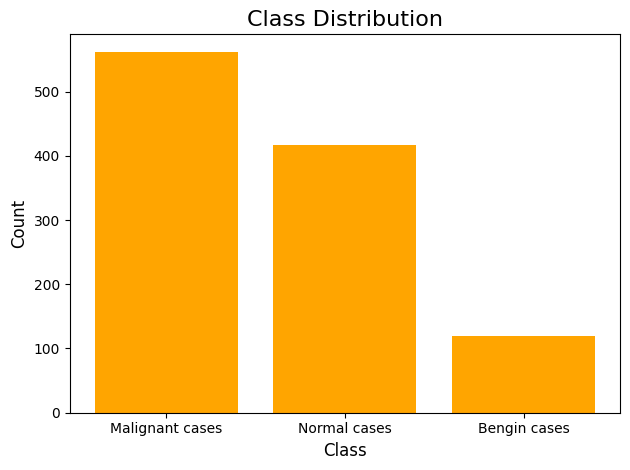

Malignant cases: 561
Normal cases: 416
Bengin cases: 120


In [5]:
labels = [s[1] for s in samples]
counts = Counter(labels)

counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))

classes = list(counts.keys())
values = list(counts.values())

bars = plt.bar(classes, values, color='orange')

plt.title('Class Distribution', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

for cls, count in counts.items():
    print(f'{cls}: {count}')

# Sample Dataset Images
Plotting 4 images per class

0 Malignant cases
1 Normal cases
2 Bengin cases


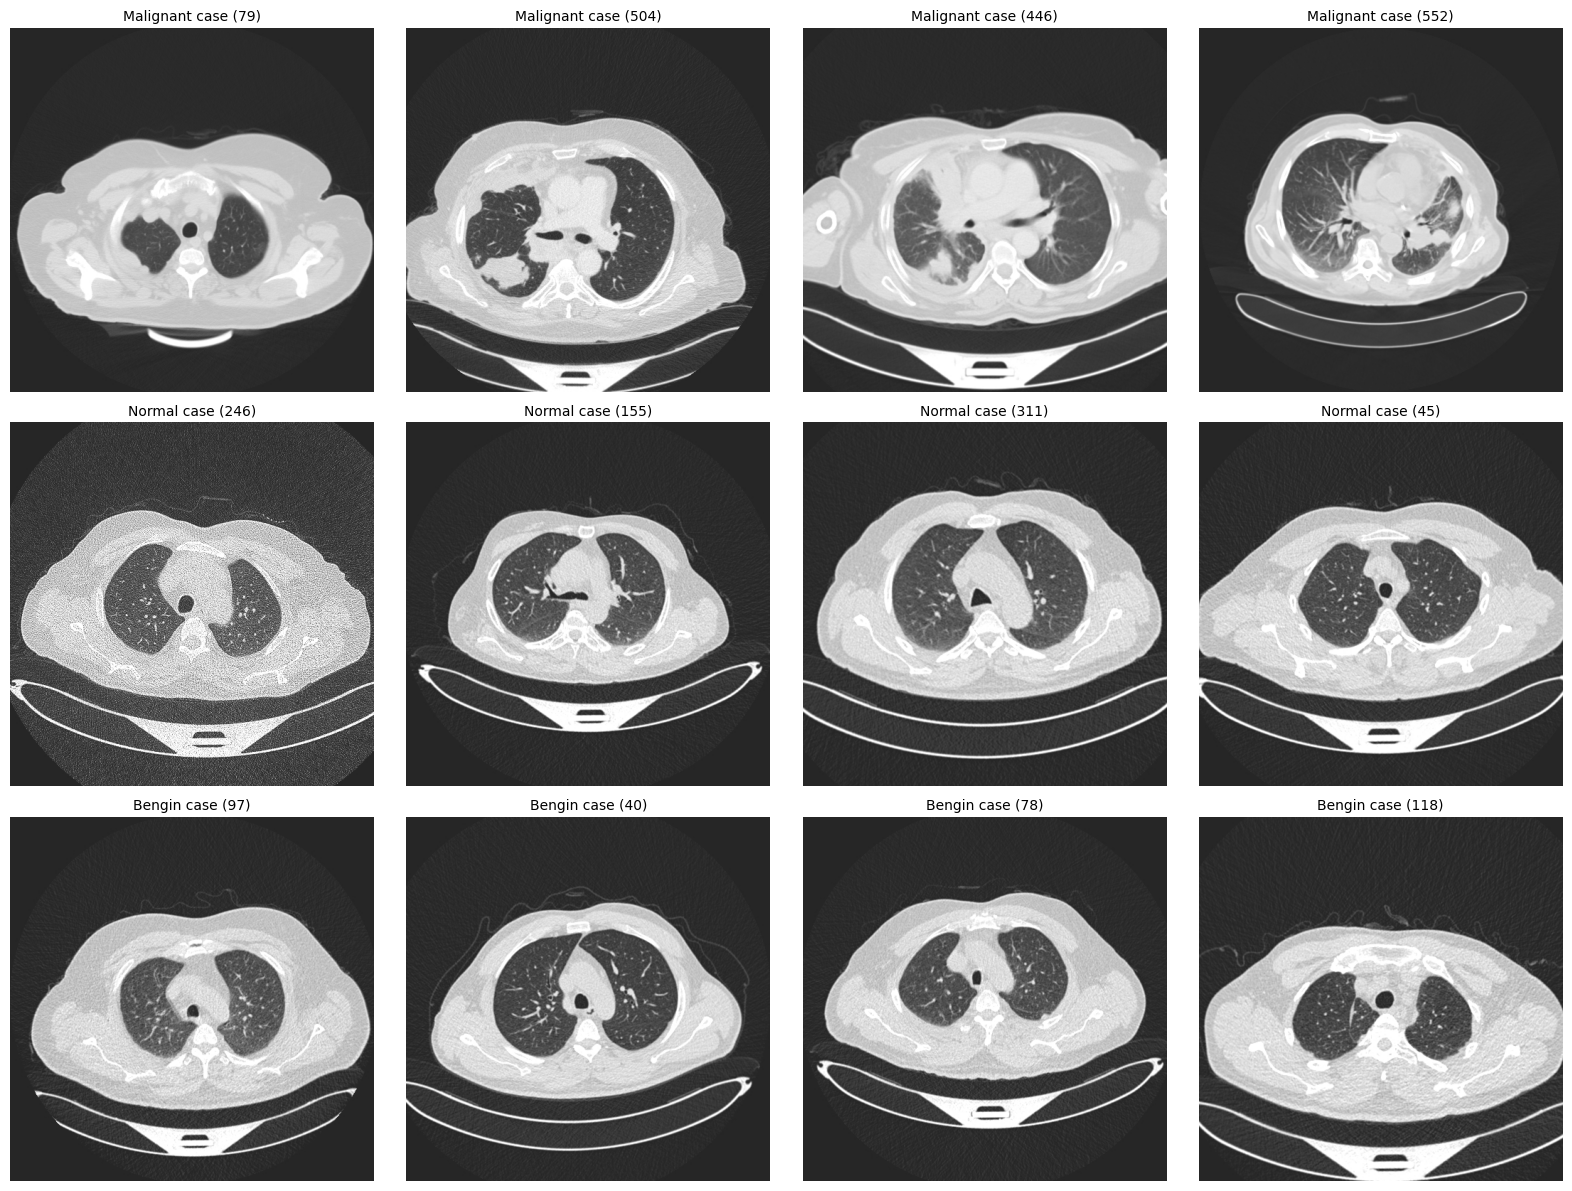

In [6]:
n_per_class = 4
fig, axes = plt.subplots(len(classes), n_per_class, figsize=(n_per_class*4, len(classes)*4))

for i, cls in enumerate(classes):
    print(i, cls)
    cls_imgs = [s[0] for s in samples if s[1] == cls][:n_per_class]
    for j, path in enumerate(cls_imgs):
        img = Image.open(path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        label = os.path.splitext(os.path.basename(path))[0]
        axes[i, j].set_title(label, fontsize=10, pad=5)
        if j == 0:
            axes[i, j].set_ylabel(cls, rotation=0, labelpad=30, fontsize=15, weight='bold')
plt.tight_layout()
plt.show()

# Dataset Class Declaration

In [7]:
class ScannedImageDataset(Dataset):
    def __init__(self, samples, class_to_idx, transform=None):
        self.samples = samples
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, cls = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.class_to_idx[cls]
        return img, label

# Split Data

In [8]:
class_to_idx = {c: i for i, c in enumerate(classes)}
paths = [s[0] for s in samples]
labels = [class_to_idx[s[1]] for s in samples]

trainval_idx, test_idx = train_test_split(
    np.arange(len(samples)), test_size=0.1, stratify=labels, random_state=SEED
)
train_idx, val_idx = train_test_split(
    trainval_idx, test_size=0.2, stratify=np.array(labels)[trainval_idx], random_state=SEED
)

train_samples = [samples[i] for i in train_idx]
val_samples = [samples[i] for i in val_idx]
test_samples = [samples[i] for i in test_idx]

print(f'Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}')

Train: 789, Val: 198, Test: 110


# Transformation & Data Loaders

Here the `mean` and `std` values are taken as per `ImageNet`

In [9]:
train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

train_ds = ScannedImageDataset(train_samples, class_to_idx, transform=train_transform)
val_ds   = ScannedImageDataset(val_samples, class_to_idx, transform=test_transform)
test_ds  = ScannedImageDataset(test_samples, class_to_idx, transform=test_transform)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE)

# ResNet-18
For transfer learning and using that to classify lung cancer images

In [10]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(classes))

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 218MB/s]


In [11]:
def trainOneEpoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, correct = 0, 0
    for imgs, labels in tqdm(loader, desc='Train', leave=False):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
    return running_loss / len(loader.dataset), correct / len(loader.dataset)


def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct = 0, 0
    preds_all, labels_all = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc='Eval', leave=True):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
    return running_loss / len(loader.dataset), correct / len(loader.dataset), \
    np.array(preds_all), np.array(labels_all)

# Training
Here the model is trained for just 5 epochs


Epoch 1/5


Eval: 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]   


Train Loss: 0.2967, Acc: 0.8948
Val   Loss: 0.2748, Acc: 0.8939
Model saved

Epoch 2/5


Eval: 100%|██████████| 7/7 [00:01<00:00,  5.61it/s]   


Train Loss: 0.0473, Acc: 0.9924
Val   Loss: 0.0798, Acc: 0.9697
Model saved

Epoch 3/5


Eval: 100%|██████████| 7/7 [00:01<00:00,  5.52it/s]   


Train Loss: 0.0176, Acc: 0.9975
Val   Loss: 0.0646, Acc: 0.9747
Model saved

Epoch 4/5


Eval: 100%|██████████| 7/7 [00:01<00:00,  5.55it/s]   


Train Loss: 0.0063, Acc: 1.0000
Val   Loss: 0.0416, Acc: 0.9899
Model saved

Epoch 5/5


Eval: 100%|██████████| 7/7 [00:01<00:00,  5.03it/s]   


Train Loss: 0.0026, Acc: 1.0000
Val   Loss: 0.0336, Acc: 0.9848
Model saved


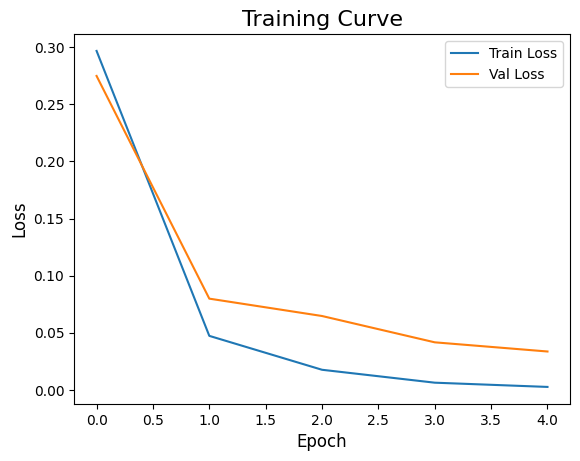

In [12]:
best_val_loss = np.inf
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch+1}/{EPOCHS}')
    train_loss, train_acc = trainOneEpoch(model, train_dl, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, val_dl, criterion)

    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}')
    print(f'Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'{OUT_DIR}/model_weights.pth')
        torch.save(model, f'{OUT_DIR}/model.pt')
        print('Model saved')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Training Curve', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.show()

# Evaluate

Eval: 100%|██████████| 4/4 [00:01<00:00,  3.02it/s]


Test Loss: 0.0910, Test Acc: 0.9818

Classification Report:
                 precision    recall  f1-score   support

Malignant cases       1.00      1.00      1.00        56
   Normal cases       0.98      0.98      0.98        42
   Bengin cases       0.92      0.92      0.92        12

       accuracy                           0.98       110
      macro avg       0.96      0.96      0.96       110
   weighted avg       0.98      0.98      0.98       110



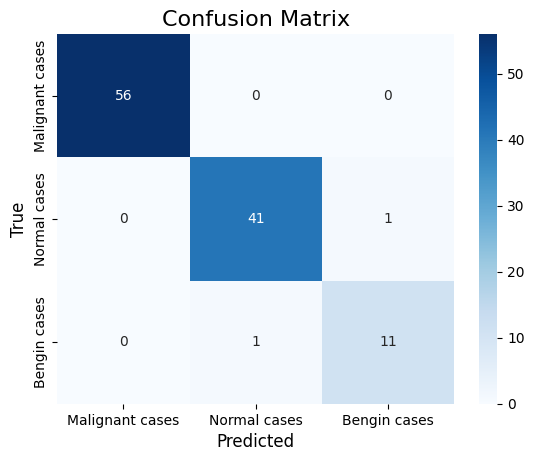

In [13]:
model.load_state_dict(torch.load(f'{OUT_DIR}/model_weights.pth'))
test_loss, test_acc, preds, labels = evaluate(model, test_dl, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

print('\nClassification Report:')
print(classification_report(labels, preds, target_names=classes))

cm = confusion_matrix(labels, preds)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [14]:
# Fix class name typo for frontend clarity
DISPLAY_CLASSES = {
    "Bengin cases": "Benign",
    "Malignant cases": "Malignant",
    "Normal cases": "Normal"
}

IDX_TO_CLASS = {v: k for k, v in class_to_idx.items()}


In [15]:
import json
import torch.nn.functional as F

def predict_image(model, img_path, transform):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1)[0]

    probs_np = probs.cpu().numpy()
    pred_idx = probs_np.argmax()
    pred_class = IDX_TO_CLASS[pred_idx]

    return {
        "predicted_label": DISPLAY_CLASSES[pred_class],
        "confidence": float(probs_np[pred_idx]),
        "probabilities": {
            DISPLAY_CLASSES[IDX_TO_CLASS[i]]: float(probs_np[i])
            for i in range(len(probs_np))
        }
    }


In [16]:
OUTPUT_JSON = "/kaggle/working/lung_cancer_predictions.json"

results = []

for path, true_cls in test_samples:
    pred = predict_image(model, path, test_transform)

    results.append({
        "image_path": path,
        "true_label": DISPLAY_CLASSES[true_cls],
        "prediction": pred["predicted_label"],
        "confidence": pred["confidence"],
        "probabilities": pred["probabilities"]
    })

final_json = {
    "model": "ResNet-18 (ImageNet pretrained)",
    "task": "Lung cancer CT image classification",
    "classes": ["Normal", "Benign", "Malignant"],
    "num_samples": len(results),
    "results": results
}

with open(OUTPUT_JSON, "w") as f:
    json.dump(final_json, f, indent=2)

print("JSON saved to:", OUTPUT_JSON)


JSON saved to: /kaggle/working/lung_cancer_predictions.json


In [17]:
import json
with open(OUTPUT_JSON) as f:
    data = json.load(f)

print(json.dumps(data["results"][0], indent=2))


{
  "image_path": "/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (136).jpg",
  "true_label": "Normal",
  "prediction": "Normal",
  "confidence": 0.9994340538978577,
  "probabilities": {
    "Malignant": 4.858826650888659e-05,
    "Normal": 0.9994340538978577,
    "Benign": 0.0005173684330657125
  }
}


In [18]:
{
  "image_path": ".../Normal cases/IMG_123.jpg",
  "true_label": "Normal",
  "prediction": "Malignant",
  "confidence": 0.9821,
  "probabilities": {
    "Normal": 0.012,
    "Benign": 0.006,
    "Malignant": 0.9821
  }
}


{'image_path': '.../Normal cases/IMG_123.jpg',
 'true_label': 'Normal',
 'prediction': 'Malignant',
 'confidence': 0.9821,
 'probabilities': {'Normal': 0.012, 'Benign': 0.006, 'Malignant': 0.9821}}